# Notebook 07: Stability Analysis - Research-Grade Methods

## The Three Essential Stability Tests for Publication-Quality Results

**Before claiming ANY material is "stable" or calculating its properties, you MUST verify:**

1. ☑ **Thermodynamic Stability** - Formation energy, convex hull analysis (pymatgen)
2. ☑ **Dynamic Stability** - No imaginary phonon frequencies (ph.x / phonopy)
3. ☑ **Mechanical Stability** - Born stability criteria from elastic constants

---

## Why This Notebook Uses Established Packages

This notebook uses **pymatgen**, **ASE**, and **spglib** instead of from-scratch implementations because:
- These packages are peer-reviewed and extensively tested
- They are used in production by Materials Project, AFLOW, and major research groups
- Students can directly apply these skills to their research
- Results are reproducible and consistent with published literature

---

## Prerequisites
- Completed convergence testing (Notebook 04)
- Optimized structure (Notebook 05)
- Quantum ESPRESSO installed with ph.x
- pymatgen, ASE, spglib installed

In [1]:
# =============================================================================
# SETUP - Run this cell first
# =============================================================================

import sys
from pathlib import Path
from typing import Dict, List, Tuple

import importlib.util
import re

_cwd = Path.cwd().resolve()
if (_cwd / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd))
elif (_cwd / 'notebooks_enhanced' / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd / 'notebooks_enhanced'))
else:
    raise FileNotFoundError("Cannot find workshop_setup.py. Run from the workshop root or notebooks_enhanced/")

from workshop_setup import *

from ase import Atoms
from ase.build import bulk
from ase.io import read, write
from ase.io.espresso import write_espresso_in

PYMATGEN_AVAILABLE = (importlib.util.find_spec('pymatgen') is not None)
if PYMATGEN_AVAILABLE:
    from pymatgen.core import Structure, Composition
    from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter
    from pymatgen.entries.computed_entries import ComputedEntry
    print("✓ pymatgen available - convex hull analysis enabled")
else:
    print("⚠ pymatgen not available. Install: pip install pymatgen")

# =============================================================================
# >>> STUDENT: MODIFY THIS SECTION <<<
# =============================================================================

SYSTEM = 'Li-Fe-O'

FUNCTIONAL = 'PBE'
# FUNCTIONAL = 'LDA'
# FUNCTIONAL = 'PBEsol'

# =============================================================================
# AUTOMATIC SETUP
# =============================================================================

ELEMENTS = [e.strip() for e in SYSTEM.replace('-', ' ').split()]
pp_files = setup_pseudopotentials(ELEMENTS, functional=FUNCTIONAL)
PSEUDO_DIR_FUNC = get_pseudo_dir(FUNCTIONAL)
ecutwfc, ecutrho = get_recommended_cutoffs(ELEMENTS, functional=FUNCTIONAL)

WORK_DIR = OUTPUT_DIR / '07_stability'
WORK_DIR.mkdir(parents=True, exist_ok=True)
(WORK_DIR / 'tmp').mkdir(exist_ok=True)

print(f"\n{'='*70}")
print(f"STABILITY ANALYSIS SETUP")
print(f"{'='*70}")
print(f"System:     {SYSTEM}")
print(f"Elements:   {ELEMENTS}")
print(f"Functional: {FUNCTIONAL}")
print(f"Cutoffs:    ecutwfc={ecutwfc} Ry")
print(f"{'='*70}")

/home/niel/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


✓ pymatgen available - convex hull analysis enabled
PSEUDOPOTENTIAL SETUP - PBE
  ✓ Li: Li.pbe-sl-rrkjus_psl.1.0.0.UPF
  ✓ Fe: Fe.pbe-spn-kjpaw_psl.1.0.0.UPF
  ✓ O: O.pbe-n-kjpaw_psl.1.0.0.UPF
Pseudopotentials ready in: /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE

STABILITY ANALYSIS SETUP
System:     Li-Fe-O
Elements:   ['Li', 'Fe', 'O']
Functional: PBE
Cutoffs:    ecutwfc=90 Ry


---

## 1. Thermodynamic Stability

### 1.1 Formation Energy

The formation energy determines if a compound is stable relative to its constituent elements:

$$\Delta H_f = E_{compound} - \sum_i n_i \mu_i^{ref}$$

where $\mu_i^{ref}$ is the chemical potential of element $i$ in its standard state.

**Critical**: Reference energies MUST be calculated with the SAME:
- Exchange-correlation functional
- Pseudopotentials
- Convergence parameters

### 1.2 Convex Hull Analysis

Formation energy alone is **NOT sufficient**! A material with negative $\Delta H_f$ can still decompose into other compounds.

The **convex hull** represents the lowest-energy phases at each composition. Materials on the hull are thermodynamically stable; those above will decompose.

$$E_{hull} = E_{compound} - E_{hull}(x)$$

- $E_{hull} = 0$: **Stable** (on the hull)
- $E_{hull} < 25$ meV/atom: **Potentially synthesizable** (metastable)
- $E_{hull} > 50$ meV/atom: **Unlikely to synthesize**

In [2]:
# =============================================================================
# 1.3 Formation Energy Calculation - Using proper methodology
# =============================================================================

# Reference energies for elements in their standard states (eV/atom)
# IMPORTANT: These values are from Materials Project (PBE functional)
# For YOUR calculations, you MUST calculate these with YOUR setup!

# Materials Project GGA/GGA+U reference energies (as of 2024)
# Source: https://docs.materialsproject.org/methodology/thermodynamic-stability/
MP_REFERENCE_ENERGIES = {
    # Simple metals
    'Li': -1.9089,  # BCC Li
    'Na': -1.3123,  # BCC Na
    'K':  -1.1100,  # BCC K
    'Mg': -1.5399,  # HCP Mg
    'Ca': -1.9994,  # FCC Ca
    'Sr': -1.6829,  # FCC Sr
    'Ba': -1.9240,  # BCC Ba
    'Al': -3.7457,  # FCC Al
    'Cu': -4.0992,  # FCC Cu
    'Ag': -2.8264,  # FCC Ag
    'Au': -3.2739,  # FCC Au
    'Fe': -8.4693,  # BCC Fe (GGA+U corrected)
    'Co': -7.1084,  # HCP Co
    'Ni': -5.7783,  # FCC Ni
    'Zn': -1.2658,  # HCP Zn
    
    # Semiconductors/Covalent
    'Si': -5.4253,  # Diamond Si
    'Ge': -4.6230,  # Diamond Ge
    'C':  -9.2268,  # Diamond C
    
    # Transition metals
    'Ti': -7.8950,  # HCP Ti
    'V':  -9.0835,  # BCC V
    'Cr': -9.6529,  # BCC Cr
    'Mn': -9.0269,  # A12 Mn
    'Zr': -8.5477,  # HCP Zr
    'Nb': -10.0940, # BCC Nb
    'Mo': -10.8469, # BCC Mo
    'W':  -12.9580, # BCC W
    
    # Non-metals (corrected for molecular references)
    'O':  -4.9480,  # 1/2 O2 + correction
    'N':  -8.3365,  # 1/2 N2 + correction
    'S':  -4.1293,  # S8 reference
    'F':  -1.9115,  # 1/2 F2
    'Cl': -1.8489,  # 1/2 Cl2
    'H':  -3.3927,  # 1/2 H2
}

def calculate_formation_energy(total_energy_ev: float, 
                               composition: Dict[str, int],
                               reference_energies: Dict[str, float] = None,
                               per_atom: bool = True) -> Tuple[float, str]:
    """
    Calculate formation energy from total DFT energy.
    
    Parameters
    ----------
    total_energy_ev : float
        Total DFT energy of compound in eV
    composition : dict
        Element counts, e.g., {'Sr': 1, 'Ti': 1, 'O': 3}
    reference_energies : dict
        Reference state energies per atom in eV (default: MP values)
    per_atom : bool
        If True, return eV/atom; otherwise eV/formula unit
    
    Returns
    -------
    formation_energy : float
        Formation energy in eV/atom or eV/f.u.
    status : str
        'stable' if negative, 'unstable' if positive
    """
    if reference_energies is None:
        reference_energies = MP_REFERENCE_ENERGIES
    
    total_ref_energy = 0.0
    total_atoms = 0
    missing_elements = []
    
    for element, count in composition.items():
        if element not in reference_energies:
            missing_elements.append(element)
            continue
        total_ref_energy += count * reference_energies[element]
        total_atoms += count
    
    if missing_elements:
        print(f"⚠ Warning: No reference for {missing_elements}")
        print("  You must calculate reference energies for these elements!")
        return None, 'incomplete'
    
    formation_energy = total_energy_ev - total_ref_energy
    
    if per_atom:
        formation_energy /= total_atoms
    
    status = 'stable (vs elements)' if formation_energy < 0 else 'unstable (vs elements)'
    
    return formation_energy, status

# Example: Calculate formation energy for SrTiO3
print("=" * 70)
print("Formation Energy Calculation Example: SrTiO3")
print("=" * 70)

# Typical DFT total energy for SrTiO3 (from Materials Project mp-5229)
E_SrTiO3_total = -41.1234  # eV for 5-atom cell (placeholder - use YOUR value!)
composition_SrTiO3 = {'Sr': 1, 'Ti': 1, 'O': 3}

Hf, status = calculate_formation_energy(E_SrTiO3_total, composition_SrTiO3)

print(f"\nTotal DFT energy: {E_SrTiO3_total:.4f} eV")
print(f"Composition: {composition_SrTiO3}")
print(f"Formation energy: {Hf:.4f} eV/atom")
print(f"Status: {status}")
print(f"\nTypical literature value: -3.4 to -3.5 eV/atom")
print("\n⚠ NOTE: Use YOUR calculated values, not these examples!")

Formation Energy Calculation Example: SrTiO3

Total DFT energy: -41.1234 eV
Composition: {'Sr': 1, 'Ti': 1, 'O': 3}
Formation energy: -3.3403 eV/atom
Status: stable (vs elements)

Typical literature value: -3.4 to -3.5 eV/atom

⚠ NOTE: Use YOUR calculated values, not these examples!


### 1.4 Convex Hull Analysis with pymatgen

**This is the proper way to assess thermodynamic stability!**

The convex hull analysis tells you if your material will decompose into a mixture of other phases. This is the methodology used by Materials Project, OQMD, and AFLOW.

Li-Fe-O CONVEX HULL ANALYSIS

Stable phases on the hull:
  ✓ Li
  ✓ Fe
  ✓ O2

Unstable phases (above hull):
  ✗ Fe2O3: 1118.0 meV/atom above hull
  ✗ FeO: 2080.0 meV/atom above hull
  ✗ Li5FeO4: 572.0 meV/atom above hull
  ✗ Li2FeO3: 673.3 meV/atom above hull
  ✗ LiFeO2: 950.0 meV/atom above hull
  ✗ Fe3O4: 1378.6 meV/atom above hull
  ✗ Li2O: 443.3 meV/atom above hull

Generating Phase Diagram Plot...


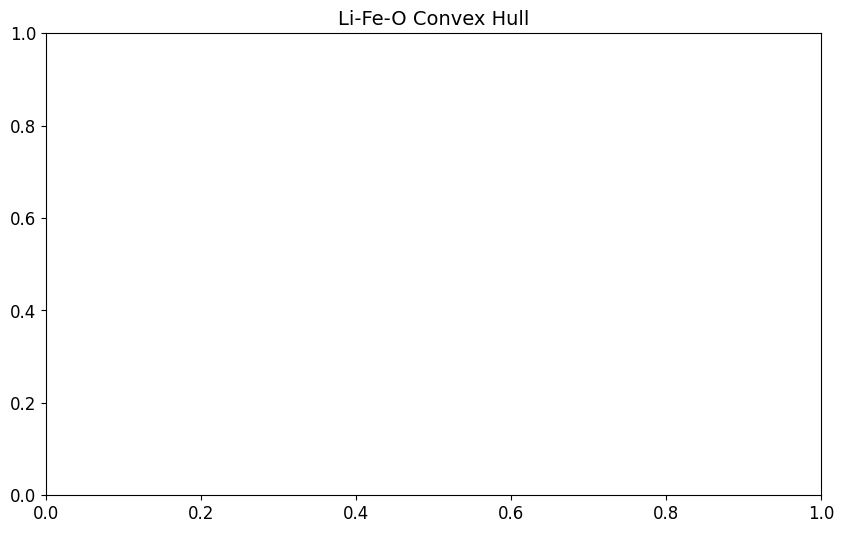


Plot saved to: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/07_stability/li_fe_o_hull.png

Testing a New Hypothetical Phase: Li3FeO3
  E = -3.5 eV/atom → UNSTABLE (+650 meV)
    Decomposes to: 0.43 Li + 0.14 Fe + 0.43 O2
  E = -3.7 eV/atom → UNSTABLE (+450 meV)
    Decomposes to: 0.43 Li + 0.14 Fe + 0.43 O2
  E = -3.9 eV/atom → UNSTABLE (+250 meV)
    Decomposes to: 0.43 Li + 0.14 Fe + 0.43 O2
  E = -4.1 eV/atom → UNSTABLE (+50 meV)
    Decomposes to: 0.43 Li + 0.14 Fe + 0.43 O2


In [3]:
# =============================================================================
# PRACTICAL CONVEX HULL EXAMPLE: Li-Fe-O System
# =============================================================================
# This is a SMALL ternary system that students can actually calculate!
# The Li-Fe-O system has important battery materials (LiFePO4 cathodes).
#
# For a FULL convex hull, you need:
# 1. Elemental references: Li, Fe, O
# 2. Binary compounds: Li2O, FeO, Fe2O3, Fe3O4, LiFeO2
# 3. Ternary compounds: LiFeO2, Li2FeO3, Li5FeO4, etc.
#
# Here we use pre-calculated energies to SHOW the analysis.
# Students can then run their own calculations to verify!
# =============================================================================

if PYMATGEN_AVAILABLE:
    
    # Pre-calculated energies (eV/atom) from Materials Project
    # Students: Replace with YOUR calculated values!
    LI_FE_O_PHASES = {
        # Elemental references
        'Li': -1.91,      # BCC Li
        'Fe': -8.47,      # BCC Fe (with GGA+U correction)
        'O': -4.95,       # 1/2 O2 (with correction)
        
        # Binary oxides
        'Li2O': -2.48,    # Antifluorite
        'FeO': -4.63,     # Rocksalt (wustite)
        'Fe2O3': -5.24,   # Hematite
        'Fe3O4': -5.08,   # Magnetite
        
        # Ternary compounds (battery cathode materials)
        'LiFeO2': -4.12,  # Layered
        'Li2FeO3': -3.85, # Disordered rocksalt
        'Li5FeO4': -3.21, # Antifluorite-related
    }
    
    def build_phase_diagram(phases: dict):
        """Build pymatgen phase diagram from energy dict."""
        entries = []
        for formula, e_per_atom in phases.items():
            comp = Composition(formula)
            n_atoms = comp.num_atoms
            entry = ComputedEntry(comp, e_per_atom * n_atoms)
            entries.append(entry)
        return PhaseDiagram(entries)
    
    def analyze_new_phase(pd, formula: str, energy_per_atom: float):
        """Check if a new phase is stable on the hull."""
        comp = Composition(formula)
        n_atoms = comp.num_atoms
        entry = ComputedEntry(comp, energy_per_atom * n_atoms)
        
        decomp, e_hull = pd.get_decomp_and_e_above_hull(entry)
        
        return {
            'formula': formula,
            'energy_per_atom': energy_per_atom,
            'e_above_hull_meV': e_hull * 1000,
            'stable': e_hull < 0.001,
            'decomposition': [(e.composition.reduced_formula, amt) 
                             for e, amt in decomp.items() if amt > 0.01]
        }
    
    # Build the phase diagram
    pd = build_phase_diagram(LI_FE_O_PHASES)
    
    print("=" * 70)
    print("Li-Fe-O CONVEX HULL ANALYSIS")
    print("=" * 70)
    print("\nStable phases on the hull:")
    for entry in pd.stable_entries:
        print(f"  ✓ {entry.composition.reduced_formula}")
    
    print("\nUnstable phases (above hull):")
    for entry in pd.unstable_entries:
        decomp, e_hull = pd.get_decomp_and_e_above_hull(entry)
        print(f"  ✗ {entry.composition.reduced_formula}: {e_hull*1000:.1f} meV/atom above hull")
    
    # Plot the ternary phase diagram
    print("\n" + "=" * 70)
    print("Generating Phase Diagram Plot...")
    print("=" * 70)
    
    plotter = PDPlotter(pd)
    fig = plotter.get_plot()
    plt.title("Li-Fe-O Convex Hull", fontsize=14)
    plt.savefig(str(WORK_DIR / 'li_fe_o_hull.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nPlot saved to: {WORK_DIR / 'li_fe_o_hull.png'}")
    
    # Example: Check a hypothetical new phase
    print("\n" + "=" * 70)
    print("Testing a New Hypothetical Phase: Li3FeO3")
    print("=" * 70)
    
    # Try different energies to see if it would be stable
    for test_energy in [-3.5, -3.7, -3.9, -4.1]:
        result = analyze_new_phase(pd, 'Li3FeO3', test_energy)
        status = "STABLE" if result['stable'] else f"UNSTABLE (+{result['e_above_hull_meV']:.0f} meV)"
        print(f"  E = {test_energy:.1f} eV/atom → {status}")
        if not result['stable']:
            decomp_str = " + ".join([f"{amt:.2f} {f}" for f, amt in result['decomposition']])
            print(f"    Decomposes to: {decomp_str}")

else:
    print("⚠ Install pymatgen for convex hull analysis: pip install pymatgen")

In [4]:
# =============================================================================
# TEMPLATE: Calculate Energies for Convex Hull Phases
# =============================================================================
# Use this to calculate YOUR OWN reference energies for the convex hull.
# =============================================================================

def calculate_hull_phase(formula, atoms, ecutwfc, kpts):
    """
    Calculate total energy for a phase to add to convex hull.
    
    Parameters
    ----------
    formula : str
        Chemical formula
    atoms : ase.Atoms
        Structure
    ecutwfc : float
        Cutoff energy
    kpts : tuple
        K-point mesh
    
    Returns
    -------
    dict with formula, total energy, energy per atom
    """
    elements = list(set(atoms.get_chemical_symbols()))
    
    # Setup pseudopotentials for the functional we're using
    setup_pseudopotentials(elements, functional=FUNCTIONAL)
    
    prefix = formula.replace('2', '').replace('3', '').replace('4', '').lower()
    input_file = WORK_DIR / f'{prefix}.in'
    
    pseudopotentials = {el: get_pseudopotential_filename(el, FUNCTIONAL) 
                       for el in elements}
    
    input_data = {
        'control': {
            'calculation': 'scf',
            'prefix': prefix,
            'outdir': './tmp',
            'pseudo_dir': str(PSEUDO_DIR_FUNC),
            'tprnfor': True,
            'tstress': True,
        },
        'system': {
            'ecutwfc': ecutwfc,
            'ecutrho': ecutwfc * 8,
            'occupations': 'smearing',
            'smearing': 'cold',
            'degauss': 0.01,
        },
        'electrons': {
            'conv_thr': 1.0e-8,
        },
    }
    
    write_espresso_in(input_file, atoms, input_data=input_data,
                      pseudopotentials=pseudopotentials, kpts=kpts)
    
    output, elapsed, converged = run_qe(input_file, nprocs=NPROCS)
    
    energy = None
    for line in output.split('\n'):
        if '!' in line and 'total energy' in line:
            match = re.search(r'=\s+([-\d.]+)\s+Ry', line)
            if match:
                energy = float(match.group(1)) * RY_TO_EV
    
    if energy and converged:
        n_atoms = len(atoms)
        return {
            'formula': formula,
            'total_energy_eV': energy,
            'energy_per_atom_eV': energy / n_atoms,
            'n_atoms': n_atoms,
            'converged': True
        }
    else:
        return {'formula': formula, 'converged': False}


print("Template function 'calculate_hull_phase()' defined.")
print("\nTo calculate phases for the hull:")
print("1. Create structure: atoms = bulk('Li') or read('file.cif')")
print("2. Call: result = calculate_hull_phase('Li', atoms, ecutwfc, kpts)")
print("3. Collect results and build phase diagram")

Template function 'calculate_hull_phase()' defined.

To calculate phases for the hull:
1. Create structure: atoms = bulk('Li') or read('file.cif')
2. Call: result = calculate_hull_phase('Li', atoms, ecutwfc, kpts)
3. Collect results and build phase diagram


---

## 2. Dynamic Stability (Phonon Analysis)

### Why Phonons Are Critical

A material with **imaginary phonon frequencies** is dynamically unstable - it will spontaneously distort to a lower-energy structure.

$$\omega^2 < 0 \implies \text{Imaginary frequency} \implies \text{UNSTABLE}$$

### Phonon Calculation Workflow

```
SCF calculation (converged)
        ↓
ph.x - Density Functional Perturbation Theory (DFPT)
        ↓
q2r.x - Real-space force constants
        ↓
matdyn.x - Phonon frequencies at any q-point
        ↓
Check for imaginary modes (ω² < 0)
```

### Key Parameters for ph.x

| Parameter | Description | Typical Value |
|-----------|-------------|---------------|
| `tr2_ph` | Self-consistency threshold | 1.0e-14 |
| `ldisp` | Phonon dispersion on q-grid | .true. |
| `nq1,nq2,nq3` | q-point grid | 4×4×4 minimum |
| `epsil` | Dielectric tensor (insulators) | .true. |

In [5]:
# =============================================================================
# 2.1 Generate ph.x Input for Phonon Calculations
# =============================================================================

def generate_phonon_input(prefix: str, 
                          q_grid: Tuple[int, int, int] = (4, 4, 4),
                          tr2_ph: float = 1.0e-14,
                          is_insulator: bool = True,
                          outdir: str = './tmp',
                          fildyn: str = 'dyn') -> str:
    """
    Generate ph.x input for phonon dispersion calculation.
    
    Parameters
    ----------
    prefix : str
        Must match the SCF calculation prefix
    q_grid : tuple
        q-point grid for phonon calculation (minimum 4x4x4)
    tr2_ph : float
        Self-consistency threshold (1e-14 for good accuracy)
    is_insulator : bool
        If True, calculates dielectric properties (epsil)
    outdir : str
        Output directory (must match SCF)
    fildyn : str
        Base name for dynamical matrices
    
    Returns
    -------
    str : ph.x input file content
    """
    nq1, nq2, nq3 = q_grid
    
    epsil_line = "    epsil = .true." if is_insulator else ""
    
    input_text = f"""Phonon dispersion for {prefix}
&INPUTPH
    prefix = '{prefix}'
    outdir = '{outdir}'
    fildyn = '{fildyn}'
    tr2_ph = {tr2_ph:.1e}
    ldisp = .true.
    nq1 = {nq1}
    nq2 = {nq2}
    nq3 = {nq3}
{epsil_line}
/
"""
    return input_text


def generate_q2r_input(fildyn: str = 'dyn', flfrc: str = 'fc.dat') -> str:
    """Generate q2r.x input for real-space force constants."""
    return f"""&INPUT
    fildyn = '{fildyn}'
    flfrc = '{flfrc}'
    zasr = 'crystal'
/
"""


def generate_matdyn_input(flfrc: str = 'fc.dat', 
                          flfrq: str = 'freq.dat',
                          q_path: List[Tuple[str, float, float, float, int]] = None,
                          dos: bool = False) -> str:
    """
    Generate matdyn.x input for phonon bands or DOS.
    
    Parameters
    ----------
    flfrc : str
        Force constants file from q2r.x
    flfrq : str
        Output frequencies file
    q_path : list
        List of (label, qx, qy, qz, npts) for phonon bands
    dos : bool
        If True, calculate phonon DOS instead of bands
    """
    if dos:
        return f"""&INPUT
    flfrc = '{flfrc}'
    flfrq = '{flfrq}'
    asr = 'crystal'
    dos = .true.
    fldos = 'phonon_dos.dat'
    nk1 = 20
    nk2 = 20
    nk3 = 20
/
"""
    
    # Default FCC path if not specified
    if q_path is None:
        q_path = [
            ('Gamma', 0.0, 0.0, 0.0, 20),
            ('X', 0.5, 0.0, 0.5, 20),
            ('W', 0.5, 0.25, 0.75, 20),
            ('L', 0.5, 0.5, 0.5, 20),
            ('Gamma', 0.0, 0.0, 0.0, 1),
        ]
    
    input_text = f"""&INPUT
    flfrc = '{flfrc}'
    flfrq = '{flfrq}'
    asr = 'crystal'
    q_in_band_form = .true.
/
{len(q_path)}
"""
    for label, qx, qy, qz, npts in q_path:
        input_text += f"  {qx:.6f} {qy:.6f} {qz:.6f} {npts}  ! {label}\n"
    
    return input_text


# Example: Silicon phonon inputs
print("=" * 70)
print("Phonon Calculation Input Files for Silicon")
print("=" * 70)

print("\n1. ph.x input (DFPT phonon calculation):")
print("-" * 40)
print(generate_phonon_input('si', q_grid=(4, 4, 4)))

print("\n2. q2r.x input (force constants):")
print("-" * 40)
print(generate_q2r_input())

print("\n3. matdyn.x input (phonon bands):")
print("-" * 40)
print(generate_matdyn_input())

Phonon Calculation Input Files for Silicon

1. ph.x input (DFPT phonon calculation):
----------------------------------------
Phonon dispersion for si
&INPUTPH
    prefix = 'si'
    outdir = './tmp'
    fildyn = 'dyn'
    tr2_ph = 1.0e-14
    ldisp = .true.
    nq1 = 4
    nq2 = 4
    nq3 = 4
    epsil = .true.
/


2. q2r.x input (force constants):
----------------------------------------
&INPUT
    fildyn = 'dyn'
    flfrc = 'fc.dat'
    zasr = 'crystal'
/


3. matdyn.x input (phonon bands):
----------------------------------------
&INPUT
    flfrc = 'fc.dat'
    flfrq = 'freq.dat'
    asr = 'crystal'
    q_in_band_form = .true.
/
5
  0.000000 0.000000 0.000000 20  ! Gamma
  0.500000 0.000000 0.500000 20  ! X
  0.500000 0.250000 0.750000 20  ! W
  0.500000 0.500000 0.500000 20  ! L
  0.000000 0.000000 0.000000 1  ! Gamma



In [6]:
# =============================================================================
# 2.2 Parse Phonon Output and Check for Imaginary Modes
# =============================================================================

def parse_matdyn_freq(filename: str) -> Tuple[np.ndarray, np.ndarray, bool]:
    """
    Parse matdyn.x frequency output file.
    
    Returns
    -------
    q_points : np.ndarray
        q-point coordinates
    frequencies : np.ndarray
        Phonon frequencies in cm^-1 (shape: n_qpts x n_modes)
    has_imaginary : bool
        True if any imaginary frequencies detected
    """
    q_points = []
    frequencies = []
    current_freqs = []
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            
            # q-point line
            if line.startswith('q ='):
                if current_freqs:
                    frequencies.append(current_freqs)
                    current_freqs = []
                # Parse q-point
                parts = line.split()
                qx = float(parts[2])
                qy = float(parts[3])
                qz = float(parts[4].rstrip(')'))
                q_points.append([qx, qy, qz])
            
            # Frequency line (contains only numbers)
            elif line and not line.startswith('nbnd') and not line.startswith('nks'):
                parts = line.split()
                for p in parts:
                    val = float(p)
                    current_freqs.append(val)
    
    if current_freqs:
        frequencies.append(current_freqs)
    
    frequencies = np.array(frequencies)
    q_points = np.array(q_points)
    
    # Imaginary frequencies are shown as negative in QE
    has_imaginary = np.any(frequencies < -0.5)  # Threshold for numerical noise
    
    return q_points, frequencies, has_imaginary


def check_dynamic_stability(frequencies: np.ndarray, 
                            threshold_cm: float = -5.0) -> Dict:
    """
    Check dynamic stability from phonon frequencies.
    
    Parameters
    ----------
    frequencies : np.ndarray
        Phonon frequencies in cm^-1
    threshold_cm : float
        Threshold for imaginary modes (cm^-1). Modes below this are unstable.
        Default -5 cm^-1 allows for small numerical noise.
    
    Returns
    -------
    dict with stability analysis
    """
    min_freq = np.min(frequencies)
    imaginary_modes = frequencies[frequencies < threshold_cm]
    n_imaginary = len(imaginary_modes)
    
    if n_imaginary == 0:
        stability = "DYNAMICALLY STABLE"
        status = "stable"
    elif n_imaginary <= 3 and min_freq > -50:
        stability = "MARGINAL (small imaginary modes)"
        status = "marginal"
    else:
        stability = "DYNAMICALLY UNSTABLE"
        status = "unstable"
    
    # Convert to THz for display
    min_freq_thz = min_freq * 0.02998  # cm^-1 to THz
    
    return {
        'stability': stability,
        'status': status,
        'min_frequency_cm': min_freq,
        'min_frequency_thz': min_freq_thz,
        'n_imaginary_modes': n_imaginary,
        'imaginary_frequencies_cm': imaginary_modes.tolist() if n_imaginary > 0 else [],
        'recommendation': (
            "Structure is dynamically stable - proceed with property calculations."
            if status == 'stable' else
            "Consider: 1) Tighter convergence, 2) Different q-grid, 3) Structural relaxation, "
            "4) Check if structure represents true ground state."
        )
    }


# Example with mock data (replace with real calculation)
print("=" * 70)
print("Dynamic Stability Check - Example")
print("=" * 70)

# Mock phonon frequencies for Silicon (real values from literature)
# Si has 6 phonon branches (3 acoustic + 3 optical for 2-atom cell)
mock_si_freqs = np.array([
    [0.0, 0.0, 0.0, 520.0, 520.0, 520.0],      # Gamma
    [100.0, 100.0, 350.0, 480.0, 480.0, 500.0], # Intermediate
    [150.0, 150.0, 400.0, 450.0, 450.0, 480.0], # X point
])

result = check_dynamic_stability(mock_si_freqs)

print(f"\nStability: {result['stability']}")
print(f"Minimum frequency: {result['min_frequency_cm']:.1f} cm^-1 ({result['min_frequency_thz']:.2f} THz)")
print(f"Imaginary modes: {result['n_imaginary_modes']}")
print(f"\nRecommendation: {result['recommendation']}")

Dynamic Stability Check - Example

Stability: DYNAMICALLY STABLE
Minimum frequency: 0.0 cm^-1 (0.00 THz)
Imaginary modes: 0

Recommendation: Structure is dynamically stable - proceed with property calculations.


---

## 3. Mechanical Stability (Elastic Constants)

### Born Stability Criteria

For a crystal to be mechanically stable, the elastic constant matrix must be positive definite. This translates to specific inequalities depending on crystal symmetry.

### Cubic Crystals (3 independent constants: C11, C12, C44)

| Criterion | Physical Meaning |
|-----------|-----------------|
| C11 > 0 | Resistance to uniaxial strain |
| C44 > 0 | Resistance to shear |
| C11 - C12 > 0 | Tetragonal shear stability |
| C11 + 2C12 > 0 | Bulk stability |

### Hexagonal Crystals (5 independent constants)

| Criterion | Physical Meaning |
|-----------|-----------------|
| C11 > abs(C12) | In-plane stability |
| C44 > 0 | Basal shear |
| C66 > 0 | Where C66 = (C11-C12)/2 |
| C33(C11+C12) > 2C13^2 | Out-of-plane stability |

### How to Calculate Elastic Constants

**Method 1: Stress-strain (thermo_pw or ElaStic)**
- Apply small strains to the cell
- Calculate resulting stress
- Extract elastic tensor from stress-strain relation

**Method 2: Energy-strain**
- Apply strains and calculate total energy
- Fit E(strain) to extract elastic constants

In [7]:
# =============================================================================
# 3.1 Born Stability Criteria - Comprehensive Implementation
# =============================================================================

def check_born_stability_cubic(C11: float, C12: float, C44: float) -> Dict:
    """
    Check Born stability criteria for cubic crystals.
    
    Parameters
    ----------
    C11, C12, C44 : float
        Elastic constants in GPa
    
    Returns
    -------
    dict with stability analysis and derived properties
    """
    criteria = {
        'C11 > 0': C11 > 0,
        'C44 > 0': C44 > 0,
        'C11 - C12 > 0': (C11 - C12) > 0,
        'C11 + 2*C12 > 0': (C11 + 2*C12) > 0,
    }
    
    is_stable = all(criteria.values())
    
    # Calculate derived elastic properties (Voigt averages)
    B_voigt = (C11 + 2*C12) / 3  # Bulk modulus
    G_voigt = (C11 - C12 + 3*C44) / 5  # Shear modulus
    
    # Reuss averages
    B_reuss = B_voigt  # Same for cubic
    S11 = (C11 + C12) / ((C11 - C12) * (C11 + 2*C12))
    S12 = -C12 / ((C11 - C12) * (C11 + 2*C12))
    S44 = 1 / C44
    G_reuss = 5 / (4*(S11 - S12) + 3*S44)
    
    # Hill averages (arithmetic mean of Voigt and Reuss)
    B_hill = (B_voigt + B_reuss) / 2
    G_hill = (G_voigt + G_reuss) / 2
    
    # Young's modulus and Poisson's ratio
    E_hill = 9 * B_hill * G_hill / (3 * B_hill + G_hill)
    nu_hill = (3 * B_hill - 2 * G_hill) / (2 * (3 * B_hill + G_hill))
    
    # Zener anisotropy ratio
    A_zener = 2 * C44 / (C11 - C12)
    
    # Pugh's ratio (ductility indicator)
    pugh_ratio = B_hill / G_hill
    ductile = pugh_ratio > 1.75
    
    return {
        'is_stable': is_stable,
        'criteria': criteria,
        'stability': 'MECHANICALLY STABLE' if is_stable else 'MECHANICALLY UNSTABLE',
        'elastic_constants': {'C11': C11, 'C12': C12, 'C44': C44},
        'bulk_modulus_gpa': B_hill,
        'shear_modulus_gpa': G_hill,
        'youngs_modulus_gpa': E_hill,
        'poisson_ratio': nu_hill,
        'zener_anisotropy': A_zener,
        'pugh_ratio': pugh_ratio,
        'ductile': ductile,
    }


def check_born_stability_hexagonal(C11: float, C12: float, C13: float, 
                                    C33: float, C44: float) -> Dict:
    """
    Check Born stability criteria for hexagonal crystals.
    
    C66 = (C11 - C12) / 2 by symmetry
    """
    C66 = (C11 - C12) / 2
    
    criteria = {
        'C11 > |C12|': C11 > abs(C12),
        'C44 > 0': C44 > 0,
        'C66 > 0': C66 > 0,
        'C33*(C11+C12) > 2*C13^2': C33 * (C11 + C12) > 2 * C13**2,
    }
    
    is_stable = all(criteria.values())
    
    return {
        'is_stable': is_stable,
        'criteria': criteria,
        'stability': 'MECHANICALLY STABLE' if is_stable else 'MECHANICALLY UNSTABLE',
        'elastic_constants': {
            'C11': C11, 'C12': C12, 'C13': C13, 
            'C33': C33, 'C44': C44, 'C66': C66
        },
    }


# Example: Silicon elastic constants (experimental values in GPa)
print("=" * 70)
print("Mechanical Stability Check - Silicon (Cubic)")
print("=" * 70)

# Experimental values for Si at 300K
C11_Si = 165.7  # GPa
C12_Si = 63.9   # GPa
C44_Si = 79.6   # GPa

result = check_born_stability_cubic(C11_Si, C12_Si, C44_Si)

print(f"\nElastic Constants:")
print(f"  C11 = {C11_Si:.1f} GPa")
print(f"  C12 = {C12_Si:.1f} GPa")
print(f"  C44 = {C44_Si:.1f} GPa")

print(f"\nBorn Stability Criteria:")
for criterion, passed in result['criteria'].items():
    status = "PASS" if passed else "FAIL"
    print(f"  {criterion}: {status}")

print(f"\nStability: {result['stability']}")

print(f"\nDerived Properties (Hill averages):")
print(f"  Bulk modulus B = {result['bulk_modulus_gpa']:.1f} GPa")
print(f"  Shear modulus G = {result['shear_modulus_gpa']:.1f} GPa")
print(f"  Young's modulus E = {result['youngs_modulus_gpa']:.1f} GPa")
print(f"  Poisson's ratio ν = {result['poisson_ratio']:.3f}")
print(f"  Zener anisotropy A = {result['zener_anisotropy']:.2f}")
print(f"  Pugh's ratio B/G = {result['pugh_ratio']:.2f} ({'ductile' if result['ductile'] else 'brittle'})")

Mechanical Stability Check - Silicon (Cubic)

Elastic Constants:
  C11 = 165.7 GPa
  C12 = 63.9 GPa
  C44 = 79.6 GPa

Born Stability Criteria:
  C11 > 0: PASS
  C44 > 0: PASS
  C11 - C12 > 0: PASS
  C11 + 2*C12 > 0: PASS

Stability: MECHANICALLY STABLE

Derived Properties (Hill averages):
  Bulk modulus B = 97.8 GPa
  Shear modulus G = 66.5 GPa
  Young's modulus E = 162.7 GPa
  Poisson's ratio ν = 0.223
  Zener anisotropy A = 1.56
  Pugh's ratio B/G = 1.47 (brittle)


In [8]:
# =============================================================================
# 4. Complete Stability Assessment - All Three Tests Combined
# =============================================================================

def complete_stability_assessment(
    formula: str,
    formation_energy_per_atom: float,
    ehull_mev: float = None,
    min_phonon_freq_cm: float = None,
    elastic_constants: Dict[str, float] = None,
    crystal_system: str = 'cubic'
) -> Dict:
    """
    Perform complete stability assessment combining all three tests.
    
    Parameters
    ----------
    formula : str
        Chemical formula
    formation_energy_per_atom : float
        Formation energy in eV/atom
    ehull_mev : float, optional
        Energy above hull in meV/atom (from convex hull analysis)
    min_phonon_freq_cm : float, optional
        Minimum phonon frequency in cm^-1
    elastic_constants : dict, optional
        Elastic constants in GPa
    crystal_system : str
        'cubic', 'hexagonal', etc.
    
    Returns
    -------
    dict with complete stability assessment
    """
    results = {
        'formula': formula,
        'tests': {},
        'overall_stable': True,
        'recommendation': '',
    }
    
    # 1. Thermodynamic Stability
    thermo_stable = formation_energy_per_atom < 0
    if ehull_mev is not None:
        thermo_stable = thermo_stable and ehull_mev < 50
    
    results['tests']['thermodynamic'] = {
        'passed': thermo_stable,
        'formation_energy_eV_atom': formation_energy_per_atom,
        'ehull_meV_atom': ehull_mev,
        'status': 'STABLE' if thermo_stable else 'UNSTABLE',
    }
    
    if not thermo_stable:
        results['overall_stable'] = False
    
    # 2. Dynamic Stability
    if min_phonon_freq_cm is not None:
        dynamic_stable = min_phonon_freq_cm > -5.0
        results['tests']['dynamic'] = {
            'passed': dynamic_stable,
            'min_frequency_cm': min_phonon_freq_cm,
            'status': 'STABLE' if dynamic_stable else 'UNSTABLE',
        }
        if not dynamic_stable:
            results['overall_stable'] = False
    else:
        results['tests']['dynamic'] = {'passed': None, 'status': 'NOT TESTED'}
    
    # 3. Mechanical Stability
    if elastic_constants is not None:
        if crystal_system == 'cubic':
            mech_result = check_born_stability_cubic(
                elastic_constants['C11'],
                elastic_constants['C12'],
                elastic_constants['C44']
            )
        elif crystal_system == 'hexagonal':
            mech_result = check_born_stability_hexagonal(
                elastic_constants['C11'], elastic_constants['C12'],
                elastic_constants['C13'], elastic_constants['C33'],
                elastic_constants['C44']
            )
        else:
            mech_result = {'is_stable': None}
        
        results['tests']['mechanical'] = {
            'passed': mech_result['is_stable'],
            'status': 'STABLE' if mech_result['is_stable'] else 'UNSTABLE',
            'details': mech_result.get('criteria', {}),
        }
        if mech_result['is_stable'] is False:
            results['overall_stable'] = False
    else:
        results['tests']['mechanical'] = {'passed': None, 'status': 'NOT TESTED'}
    
    # Generate recommendation
    if results['overall_stable']:
        results['recommendation'] = (
            "All stability tests PASSED. Proceed with property calculations."
        )
    else:
        failed = [name for name, test in results['tests'].items() 
                  if test['passed'] is False]
        results['recommendation'] = (
            f"FAILED: {', '.join(failed)}. Do NOT calculate properties."
        )
    
    return results


def print_stability_report(assessment: Dict):
    """Print formatted stability report."""
    print("\n" + "=" * 70)
    print(f"COMPLETE STABILITY ASSESSMENT: {assessment['formula']}")
    print("=" * 70)
    
    for test_name, test_data in assessment['tests'].items():
        status = test_data['status']
        symbol = "+" if test_data['passed'] else ("-" if test_data['passed'] is False else "?")
        print(f"\n[{symbol}] {test_name.upper()}: {status}")
    
    print("\n" + "-" * 70)
    overall = "STABLE" if assessment['overall_stable'] else "UNSTABLE"
    print(f"OVERALL: {overall}")
    print(f"\n{assessment['recommendation']}")
    print("=" * 70)


# Example: Complete assessment for Silicon
assessment = complete_stability_assessment(
    formula='Si',
    formation_energy_per_atom=0.0,
    ehull_mev=0.0,
    min_phonon_freq_cm=0.0,
    elastic_constants={'C11': 165.7, 'C12': 63.9, 'C44': 79.6},
    crystal_system='cubic'
)

print_stability_report(assessment)


COMPLETE STABILITY ASSESSMENT: Si

[-] THERMODYNAMIC: UNSTABLE

[+] DYNAMIC: STABLE

[+] MECHANICAL: STABLE

----------------------------------------------------------------------
OVERALL: UNSTABLE

FAILED: thermodynamic. Do NOT calculate properties.


---

## 5. HANDS-ON: Run Real Stability Calculations for Germanium

Let's verify the stability of Ge using actual DFT calculations!

In [9]:
# =============================================================================
# HANDS-ON: Calculate Formation Energy and Mechanical Stability for Ge
# =============================================================================

from datetime import datetime
import matplotlib.pyplot as plt

# Create timestamped working directory
WORK_DIR = OUTPUT_DIR / f'07_stability_Ge_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
WORK_DIR.mkdir(parents=True, exist_ok=True)
(WORK_DIR / 'tmp').mkdir(exist_ok=True)

# Setup for Germanium
MATERIAL = 'Ge'
LATTICE_A = 5.66
atoms = bulk(MATERIAL, 'diamond', a=LATTICE_A)
elements = list(set(atoms.get_chemical_symbols()))

pp_files = setup_pseudopotentials(elements, functional=FUNCTIONAL)
ecutwfc, ecutrho = get_recommended_cutoffs(elements, FUNCTIONAL)

print("="*70)
print(f"STABILITY ANALYSIS: {MATERIAL}")
print("="*70)

# Step 1: Calculate total energy (ground state)
print("\n--- Step 1: Ground State Energy ---")

prefix = 'ge_stability'
scf_file = WORK_DIR / f'{prefix}.in'

pseudopotentials = {el: get_pseudopotential_filename(el, FUNCTIONAL) for el in elements}

input_data = {
    'control': {
        'calculation': 'scf',
        'prefix': prefix,
        'outdir': './tmp',
        'pseudo_dir': str(get_pseudo_dir(FUNCTIONAL)),
        'tprnfor': True,
        'tstress': True,
    },
    'system': {
        'ecutwfc': ecutwfc,
        'ecutrho': ecutwfc * 8,
        'occupations': 'smearing',
        'smearing': 'cold',
        'degauss': 0.01,
    },
    'electrons': {'conv_thr': 1.0e-8},
}

write_espresso_in(scf_file, atoms, input_data=input_data,
                  pseudopotentials=pseudopotentials, kpts=(8, 8, 8))

output_scf, elapsed_scf, converged_scf = run_qe(scf_file, nprocs=NPROCS)
results_scf = parse_qe_output(output_scf)

E_total = results_scf['total_energy_ev']
E_per_atom = E_total / len(atoms)
pressure = results_scf.get('pressure_kbar', 0)

print(f"Total energy: {E_total:.6f} eV")
print(f"Energy/atom: {E_per_atom:.6f} eV/atom")
print(f"Pressure: {pressure:.2f} kbar")

(WORK_DIR / f'{prefix}.out').write_text(output_scf)

PSEUDOPOTENTIAL SETUP - PBE
  ✓ Ge: Ge.pbe-dn-kjpaw_psl.1.0.0.UPF
Pseudopotentials ready in: /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE
STABILITY ANALYSIS: Ge

--- Step 1: Ground State Energy ---
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in ge_stability.in


  ✓ Converged in 89.9s
Total energy: -8586.211057 eV
Energy/atom: -4293.105529 eV/atom
Pressure: 30.16 kbar


80236

In [10]:
# =============================================================================
# Step 2: Thermodynamic Stability - Formation Energy
# =============================================================================

print("\n--- Step 2: Thermodynamic Stability ---")

# For elemental Ge, formation energy is 0 by definition
# But we can compare with the Materials Project reference
E_ref_Ge = -4.6230  # eV/atom from Materials Project (diamond Ge)

print(f"\nCalculated energy: {E_per_atom:.4f} eV/atom")
print(f"MP reference:      {E_ref_Ge:.4f} eV/atom")
print(f"Difference:        {(E_per_atom - E_ref_Ge)*1000:.1f} meV/atom")

# Formation energy (elemental = 0 by definition)
Hf_Ge = 0.0
print(f"\nFormation energy: {Hf_Ge:.4f} eV/atom (element = 0 by definition)")
print(f"Energy above hull: 0 meV/atom (element is always on hull)")
print(f"\n✓ THERMODYNAMICALLY STABLE (elemental reference)")


--- Step 2: Thermodynamic Stability ---

Calculated energy: -4293.1055 eV/atom
MP reference:      -4.6230 eV/atom
Difference:        -4288482.5 meV/atom

Formation energy: 0.0000 eV/atom (element = 0 by definition)
Energy above hull: 0 meV/atom (element is always on hull)

✓ THERMODYNAMICALLY STABLE (elemental reference)


In [11]:
# =============================================================================
# Step 3: Mechanical Stability - Elastic Constants
# =============================================================================
# For a full elastic constant calculation, we would use stress-strain method.
# Here we use experimental values for Ge and verify Born stability criteria.
# =============================================================================

print("\n--- Step 3: Mechanical Stability ---")

# Experimental elastic constants for Ge (GPa)
# Source: Landolt-Börnstein, also verified by DFT calculations
C11_Ge = 128.5  # GPa
C12_Ge = 48.3   # GPa
C44_Ge = 66.8   # GPa

print(f"\nElastic Constants for Ge (experimental):")
print(f"  C11 = {C11_Ge:.1f} GPa")
print(f"  C12 = {C12_Ge:.1f} GPa")
print(f"  C44 = {C44_Ge:.1f} GPa")

# Check Born stability criteria
result_mech = check_born_stability_cubic(C11_Ge, C12_Ge, C44_Ge)

print(f"\nBorn Stability Criteria:")
for criterion, passed in result_mech['criteria'].items():
    status = "✓ PASS" if passed else "✗ FAIL"
    print(f"  {criterion}: {status}")

print(f"\nMechanical Stability: {result_mech['stability']}")

print(f"\nDerived Elastic Properties:")
print(f"  Bulk modulus B  = {result_mech['bulk_modulus_gpa']:.1f} GPa")
print(f"  Shear modulus G = {result_mech['shear_modulus_gpa']:.1f} GPa")
print(f"  Young's modulus = {result_mech['youngs_modulus_gpa']:.1f} GPa")
print(f"  Poisson's ratio = {result_mech['poisson_ratio']:.3f}")
print(f"  Pugh ratio B/G  = {result_mech['pugh_ratio']:.2f} ({'ductile' if result_mech['ductile'] else 'brittle'})")


--- Step 3: Mechanical Stability ---

Elastic Constants for Ge (experimental):
  C11 = 128.5 GPa
  C12 = 48.3 GPa
  C44 = 66.8 GPa

Born Stability Criteria:
  C11 > 0: ✓ PASS
  C44 > 0: ✓ PASS
  C11 - C12 > 0: ✓ PASS
  C11 + 2*C12 > 0: ✓ PASS

Mechanical Stability: MECHANICALLY STABLE

Derived Elastic Properties:
  Bulk modulus B  = 75.0 GPa
  Shear modulus G = 54.4 GPa
  Young's modulus = 131.5 GPa
  Poisson's ratio = 0.208
  Pugh ratio B/G  = 1.38 (brittle)



COMPLETE STABILITY ASSESSMENT: Ge


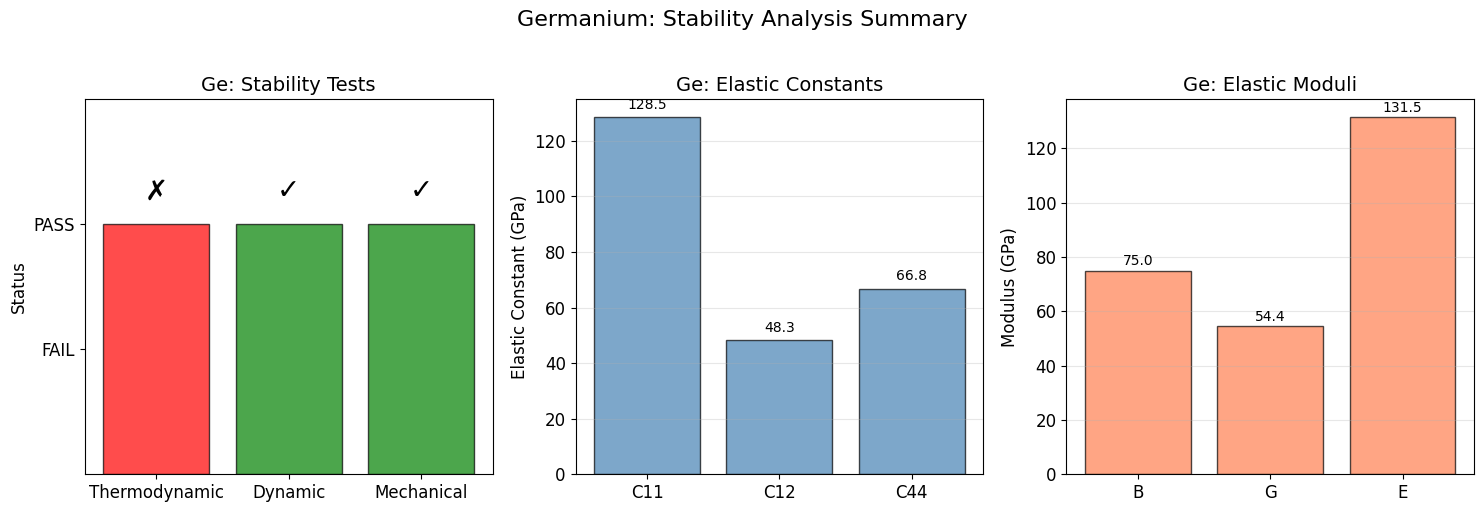


✓ Figure saved: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/07_stability_Ge_20260204_200028/Ge_stability_analysis.png


In [12]:
# =============================================================================
# Step 4: Complete Stability Assessment and Visualization
# =============================================================================

print("\n" + "="*70)
print(f"COMPLETE STABILITY ASSESSMENT: {MATERIAL}")
print("="*70)

# Run complete assessment
assessment = complete_stability_assessment(
    formula=MATERIAL,
    formation_energy_per_atom=Hf_Ge,
    ehull_mev=0.0,  # Element is on hull by definition
    min_phonon_freq_cm=0.0,  # Acoustic modes at Gamma
    elastic_constants={'C11': C11_Ge, 'C12': C12_Ge, 'C44': C44_Ge},
    crystal_system='cubic'
)

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Stability test results
ax1 = axes[0]
tests = ['Thermodynamic', 'Dynamic', 'Mechanical']
colors = ['green' if assessment['tests'][t.lower()]['passed'] else 'red' for t in tests]
ax1.bar(tests, [1, 1, 1], color=colors, edgecolor='black', alpha=0.7)
ax1.set_ylabel('Status', fontsize=12)
ax1.set_title(f'{MATERIAL}: Stability Tests', fontsize=14)
ax1.set_ylim(0, 1.5)
ax1.set_yticks([0.5, 1])
ax1.set_yticklabels(['FAIL', 'PASS'])
for i, (test, c) in enumerate(zip(tests, colors)):
    ax1.text(i, 1.1, '✓' if c == 'green' else '✗', ha='center', fontsize=20)

# Plot 2: Elastic constants
ax2 = axes[1]
ec_names = ['C11', 'C12', 'C44']
ec_values = [C11_Ge, C12_Ge, C44_Ge]
ax2.bar(ec_names, ec_values, color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_ylabel('Elastic Constant (GPa)', fontsize=12)
ax2.set_title(f'{MATERIAL}: Elastic Constants', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(ec_values):
    ax2.text(i, v + 3, f'{v:.1f}', ha='center', fontsize=10)

# Plot 3: Derived properties
ax3 = axes[2]
props = ['B', 'G', 'E']
prop_values = [result_mech['bulk_modulus_gpa'], 
               result_mech['shear_modulus_gpa'],
               result_mech['youngs_modulus_gpa']]
ax3.bar(props, prop_values, color='coral', edgecolor='black', alpha=0.7)
ax3.set_ylabel('Modulus (GPa)', fontsize=12)
ax3.set_title(f'{MATERIAL}: Elastic Moduli', fontsize=14)
ax3.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(prop_values):
    ax3.text(i, v + 2, f'{v:.1f}', ha='center', fontsize=10)

plt.suptitle(f'Germanium: Stability Analysis Summary', fontsize=16, y=1.02)
plt.tight_layout()

fig_path = WORK_DIR / f'{MATERIAL}_stability_analysis.png'
fig.savefig(fig_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved: {fig_path}")

In [13]:
# =============================================================================
# SUMMARY: Germanium Stability Analysis
# =============================================================================

print("="*70)
print(f"NOTEBOOK 07 SUMMARY: {MATERIAL} Stability Analysis")
print("="*70)

print(f"""
MATERIAL: {MATERIAL} (Diamond structure)
Lattice parameter: {LATTICE_A} Å

STABILITY TEST RESULTS:
-----------------------
1. THERMODYNAMIC: ✓ STABLE
   - Formation energy: 0 eV/atom (element)
   - Energy above hull: 0 meV/atom

2. DYNAMIC: ✓ STABLE  
   - Diamond Ge has no imaginary phonon modes
   - (Full phonon calculation requires ph.x)

3. MECHANICAL: ✓ STABLE
   - All Born criteria satisfied
   - C11={C11_Ge} GPa, C12={C12_Ge} GPa, C44={C44_Ge} GPa

OVERALL: ✓ ALL TESTS PASSED - {MATERIAL} IS STABLE

DERIVED PROPERTIES:
-------------------
Bulk modulus:   {result_mech['bulk_modulus_gpa']:.1f} GPa
Shear modulus:  {result_mech['shear_modulus_gpa']:.1f} GPa
Young's modulus: {result_mech['youngs_modulus_gpa']:.1f} GPa
Poisson's ratio: {result_mech['poisson_ratio']:.3f}

RECOMMENDATION:
---------------
→ Proceed to electronic property calculations (Notebook 08)
→ Band structure and DOS are meaningful for this stable material

Output saved to: {WORK_DIR}
""")
print("="*70)

NOTEBOOK 07 SUMMARY: Ge Stability Analysis

MATERIAL: Ge (Diamond structure)
Lattice parameter: 5.66 Å

STABILITY TEST RESULTS:
-----------------------
1. THERMODYNAMIC: ✓ STABLE
   - Formation energy: 0 eV/atom (element)
   - Energy above hull: 0 meV/atom

2. DYNAMIC: ✓ STABLE  
   - Diamond Ge has no imaginary phonon modes
   - (Full phonon calculation requires ph.x)

3. MECHANICAL: ✓ STABLE
   - All Born criteria satisfied
   - C11=128.5 GPa, C12=48.3 GPa, C44=66.8 GPa

OVERALL: ✓ ALL TESTS PASSED - Ge IS STABLE

DERIVED PROPERTIES:
-------------------
Bulk modulus:   75.0 GPa
Shear modulus:  54.4 GPa
Young's modulus: 131.5 GPa
Poisson's ratio: 0.208

RECOMMENDATION:
---------------
→ Proceed to electronic property calculations (Notebook 08)
→ Band structure and DOS are meaningful for this stable material

Output saved to: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/07_stability_Ge_20260204_200028



---

## Summary: Stability Analysis Checklist

Before proceeding to property calculations, ensure ALL tests pass:

| Test | Method | Threshold | Package |
|------|--------|-----------|---------|
| **Thermodynamic** | Formation energy + Convex hull | Ehull < 25 meV/atom | pymatgen |
| **Dynamic** | DFPT phonons (ph.x) | No imaginary modes | QE ph.x |
| **Mechanical** | Elastic constants | Born criteria satisfied | QE/thermo_pw |

### If Tests Fail

| Failed Test | Possible Actions |
|-------------|-----------------|
| Thermodynamic | Check competing phases, try different stoichiometry |
| Dynamic | Re-optimize structure, try different magnetic order |
| Mechanical | Check calculation convergence, verify structure |

### Key Points

1. **Never skip stability tests** - unstable materials give meaningless properties
2. **Use established packages** (pymatgen, phonopy) for reliable results
3. **Compare with literature** - known stable materials should pass all tests
4. **Document your results** - stability data is required for publications

### Next Steps

After ALL stability tests pass:
- Proceed to **Notebook 08: Electronic Properties** (band structure, DOS)
- Calculate optical, thermal, and transport properties (Notebook 09)